# Self-Driving Car Engineer Nanodegree

## Deep Learning

## Project: Build a Traffic Sign Recognition Classifier

---
## Step 0: Load The Data

In [1]:
# Load pickled data
import pickle

training_file = "data/train.p"
validation_file = "data/valid.p"
testing_file = "data/test.p"

# Load training-, validation-, and test-data
with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(validation_file, mode='rb') as f:
    valid = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)

# split data into images and labels
X_train, y_train = train['features'], train['labels']
X_valid, y_valid = valid['features'], valid['labels']
X_test, y_test = test['features'], test['labels']

---

## Step 1: Dataset Summary & Exploration

### Provide a Basic Summary of the Data Set Using Python, Numpy and/or Pandas

In [2]:
# Print some information on the data

n_train = len(X_train)
n_test = len(X_test)
n_classes = len(set(y_train))
image_shape = X_train[0].shape

print("Number of training examples =", n_train)
print("Number of testing examples =", n_test)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)

Number of training examples = 34799
Number of testing examples = 12630
Image data shape = (32, 32, 3)
Number of classes = 43


### Include an exploratory visualization of the dataset

1  -  Speed limit (30km/h)


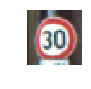

2  -  Speed limit (50km/h)


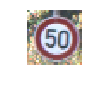

3  -  Speed limit (60km/h)


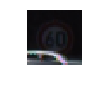

4  -  Speed limit (70km/h)


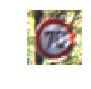

5  -  Speed limit (80km/h)


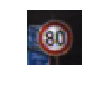

6  -  End of speed limit (80km/h)


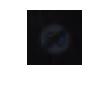

7  -  Speed limit (100km/h)


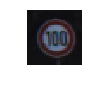

8  -  Speed limit (120km/h)


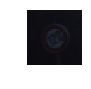

9  -  No passing


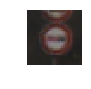

10  -  No passing for vehicles over 3.5 metric tons


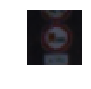

11  -  Right-of-way at the next intersection


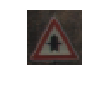

12  -  Priority road


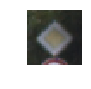

13  -  Yield


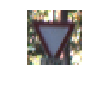

14  -  Stop


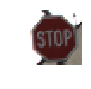

15  -  No vehicles


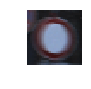

16  -  Vehicles over 3.5 metric tons prohibited


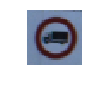

17  -  No entry


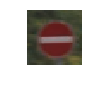

18  -  General caution


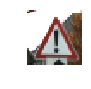

19  -  Dangerous curve to the left


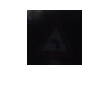

20  -  Dangerous curve to the right


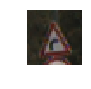

21  -  Double curve


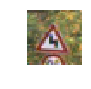

22  -  Bumpy road


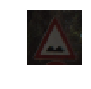

23  -  Slippery road


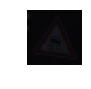

24  -  Road narrows on the right


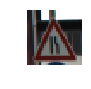

25  -  Road work


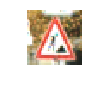

26  -  Traffic signals


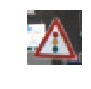

27  -  Pedestrians


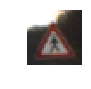

28  -  Children crossing


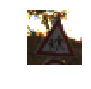

29  -  Bicycles crossing


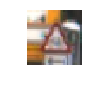

30  -  Beware of ice/snow


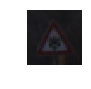

31  -  Wild animals crossing


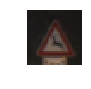

32  -  End of all speed and passing limits


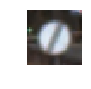

33  -  Turn right ahead


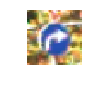

34  -  Turn left ahead


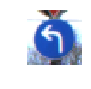

35  -  Ahead only


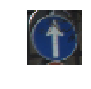

36  -  Go straight or right


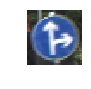

37  -  Go straight or left


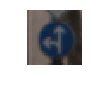

38  -  Keep right


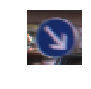

39  -  Keep left


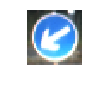

40  -  Roundabout mandatory


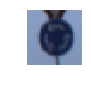

41  -  End of no passing


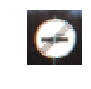

42  -  End of no passing by vehicles over 3.5 metric tons


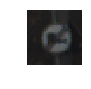

In [3]:
import matplotlib.pyplot as plt
from numpy import where
import pandas as pd

# Visualizations will be shown in the notebook.
%matplotlib inline

# Load class names
classes = pd.read_csv('signnames.csv', sep=',',header=1)

def previewImage(image, label, name):
    print(label, " - ", name)
    plt.figure(figsize = (1,1))
    plt.imshow(image)
    plt.axis('off')
    plt.show()

# for each class find and render 1 example from test set
for label, name in classes.values:
    idx = where(y_test == label)[0][0]
    previewImage(X_test[idx], label, name)


----

## Step 2: Design a Model Architecture

### Pre-process the Data Set (normalization and rotated duplication)

In [4]:
from numpy import subtract
from numpy import divide
import cv2

def normalize(images):
    images_prep = []
    for image in images:
        images_prep.append(divide(subtract(image, 128.0), 128.0))
    return images_prep

def rotate(image, angle):
    M = cv2.getRotationMatrix2D((image.shape[0] / 2, image.shape[1] / 2), angle, 1)
    return cv2.warpAffine(image, M, (image.shape[0], image.shape[1]))

# increase number of samples for training by modifying them slightly
def duplicate(images, labels):
    images_dup = []
    labels_dup = []
    for image in images:
        # original
        images_dup.append(image)
        # rotate +5
        images_dup.append(rotate(image, 5))
        # rotate -5
        images_dup.append(rotate(image, -5))
        # rotate +10
        images_dup.append(rotate(image, 10))
        # rotate -10
        images_dup.append(rotate(image, -10))
    for label in labels:
        for duplicates in range(5):
            labels_dup.append(label)
    return images_dup, labels_dup

X_train, y_train = duplicate(X_train, y_train)
print("New number of training samples:", len(X_train))
X_train = normalize(X_train)
X_valid = normalize(X_valid)
X_test = normalize(X_test)

New number of training samples: 173995


### Model Architecture

In [5]:
import tensorflow as tf

EPOCHS = 10
BATCH_SIZE = 256

In [6]:
# implementation of the actual network
from tensorflow.contrib.layers import flatten

def SignNet(sign, shape, num_labels):
    # constants used for tf.truncated_normal
    mu = 0
    sigma = 0.1    
    
    # Layer 1: Convolutional.
    # Input = 32x32x3 (width x height  x 3)
    # Output = 28x28x6 (width-4) x (height-4) x 6
    # filter with size=5x5, stride=1
    l1_W = tf.Variable(tf.truncated_normal(shape=(5, 5, 3, 6), mean=mu, stddev=sigma))
    l1_b = tf.Variable(tf.zeros(6))
    l1_strides = [1, 1, 1, 1]
    l1 = tf.nn.conv2d(sign, l1_W, strides=l1_strides, padding='VALID') + l1_b
    l1 = tf.nn.relu(l1)

    # maximum pooling to reduce size to 14x14x6 / (width-4)/2 x (height-4)/2 x 6
    l1p_kernel = [1, 2, 2, 1]
    l1p_strides = [1, 2, 2, 1]
    l1p = tf.nn.max_pool(l1, ksize=l1p_kernel, strides=l1p_strides, padding='VALID')    
    
    # Layer 2: Convolutional.
    # Input = (width-4)/2 x (height-4)/2 x 6
    # Output = ((width-4)/2-4) x ((height-4)/2-4) x 16
    l2_W = tf.Variable(tf.truncated_normal(shape=(5, 5, 6, 16), mean=mu, stddev=sigma))
    l2_b = tf.Variable(tf.zeros(16))
    l2_strides = [1, 1, 1, 1]
    l2 = tf.nn.conv2d(l1p, l2_W, strides=l2_strides, padding='VALID') + l2_b
    l2 = tf.nn.relu(l2)
    
    # maximum pooling to reduce size to 5x5x16 / ((width-4)/2-4)/2 x ((height-4)/2-4)/2 x 16
    l2p_kernel = [1, 2, 2, 1]
    l2p_strides = [1, 2, 2, 1]
    l2p = tf.nn.max_pool(l2, ksize=l2p_kernel, strides=l2p_strides, padding='VALID')
    
    # Flatten.
    # Input = 5x5x16 / ((width-4)/2-4)/2 x ((height-4)/2-4)/2 x 16
    # Output = 400 / ((width-4)/2-4)/2 * ((height-4)/2-4)/2 * 16
    flat = flatten(l2p)
    flat_len = 400 # FIXME

    # Layer 3: Fully Connected, cut to 2/3
    # Input = 400 / ((width-4)/2-4)/2 * ((height-4)/2-4)/2 * 16
    # Output = 200 / ((width-4)/2-4)/2 * ((height-4)/2-4)/2 * 16 / 2
    l3_len = 267 # FIXME
    l3_W = tf.Variable(tf.truncated_normal(shape=(flat_len, l3_len), mean=mu, stddev=sigma))
    l3_b = tf.Variable(tf.zeros(l3_len))
    l3 = tf.add(tf.matmul(flat, l3_W), l3_b)
    l3 = tf.nn.relu(l3)

    # Layer 4: Fully Connected, vut to 2/3
    # Input = 200 / ((width-4)/2-4)/2 * ((height-4)/2-4)/2 * 16 / 2
    # Input = 100 / ((width-4)/2-4)/2 * ((height-4)/2-4)/2 * 16 / 2 / 2
    l4_len = 178 # FIXME
    l4_W = tf.Variable(tf.truncated_normal(shape=(l3_len, l4_len), mean=mu, stddev=sigma))
    l4_b = tf.Variable(tf.zeros(l4_len))
    l4 = tf.add(tf.matmul(l3, l4_W), l4_b)
    l4 = tf.nn.relu(l4)

    # Layer 5: Fully Connected. Input = 84. Output = 10.
    l5_W = tf.Variable(tf.truncated_normal(shape=(l4_len, num_labels), mean=mu, stddev=sigma))
    l5_b = tf.Variable(tf.zeros(num_labels))
    logits = tf.add(tf.matmul(l4, l5_W), l5_b)

    return logits

In [7]:
# placeholders for batches(x=input images, y=output labels)

sign = tf.placeholder(tf.float32, (None, image_shape[0], image_shape[1], image_shape[2]))
y = tf.placeholder(tf.int32, (None))
one_hot_y = tf.one_hot(y, n_classes)

In [8]:
# training pipeline

rate = 0.001
logits = SignNet(sign, image_shape, n_classes)
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=one_hot_y)
loss_operation = tf.reduce_mean(cross_entropy)
optimizer = tf.train.AdamOptimizer(learning_rate = rate)
training_operation = optimizer.minimize(loss_operation)

In [9]:
correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(one_hot_y, 1))
accuracy_operation = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
saver = tf.train.Saver()

def evaluate(X_data, y_data):
    num_examples = len(X_data)
    total_accuracy = 0
    sess = tf.get_default_session()
    for offset in range(0, num_examples, BATCH_SIZE):
        batch_x, batch_y = X_data[offset:offset+BATCH_SIZE], y_data[offset:offset+BATCH_SIZE]
        accuracy = sess.run(accuracy_operation, feed_dict={sign: batch_x, y: batch_y})
        total_accuracy += (accuracy * len(batch_x))
    return 100 * total_accuracy / num_examples

### Train and Validate the Model

In [10]:
from sklearn.utils import shuffle

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    num_examples = len(X_train)
    
    print("Training...")
    print()
    for i in range(EPOCHS):
        X_train, y_train = shuffle(X_train, y_train)
        for offset in range(0, num_examples, BATCH_SIZE):
            end = offset + BATCH_SIZE
            batch_x, batch_y = X_train[offset:end], y_train[offset:end]
            sess.run(training_operation, feed_dict={sign: batch_x, y: batch_y})

        validation_accuracy = evaluate(X_valid, y_valid)
        print("EPOCH {} ...".format(i+1))
        print("Validation Accuracy = {:2.2f}%".format(validation_accuracy))
        print()
        
    saver.save(sess, './network')
    print("Model saved")

Training...

EPOCH 1 ...
Validation Accuracy = 84.44

EPOCH 2 ...
Validation Accuracy = 88.66

EPOCH 3 ...
Validation Accuracy = 90.82

EPOCH 4 ...
Validation Accuracy = 90.84

EPOCH 5 ...
Validation Accuracy = 91.41

EPOCH 6 ...
Validation Accuracy = 91.00

EPOCH 7 ...
Validation Accuracy = 93.15

EPOCH 8 ...
Validation Accuracy = 93.13

EPOCH 9 ...
Validation Accuracy = 94.83

EPOCH 10 ...
Validation Accuracy = 94.04

Model saved


### Test the Model

In [11]:
with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('.'))

    test_accuracy = evaluate(X_test, y_test)
    print("Test Accuracy = {:2.2f}%".format(test_accuracy))

Test Accuracy = 93.80%


---

## Step 3: Test a Model on New Images

### Load and Output the Images

1  -  Speed limit (30km/h)


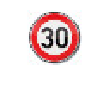

3  -  Speed limit (60km/h)


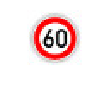

12  -  Priority road


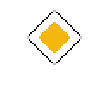

13  -  Yield


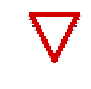

18  -  General caution


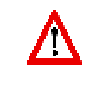

In [12]:
import os
from scipy import misc
from numpy import uint8

X_samples = []
y_samples = []
for label, name in classes.values:
    file = "data/extra/{}.png".format(label)
    if os.path.isfile(file):
        image = misc.imread(file)
        previewImage(image, label, name)
        X_samples.append(image)
        y_samples.append(uint8(label))

X_samples = normalize(X_samples)

### Predict the Sign Type for Each Image & Analyze Performance

In [13]:
with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('.'))
    predicted = sess.run(tf.nn.top_k(tf.nn.softmax(logits), k=1),feed_dict={sign: X_samples, y: y_samples})[1]

correct_samples = 0
for i in range(len(X_samples)):
    if (y_samples[i] == predicted[i]):
        correct_samples += 1
    print("sample:", y_samples[i], "- predicted:", predicted[i])

sample_accuracy = 100.0 / len(y_samples) * correct_samples
print("Sample Accuracy = {:2.2f}% ({} out of {})".format(sample_accuracy, correct_samples, len(y_samples)))

sample: 1 - predicted: [1]
sample: 3 - predicted: [3]
sample: 12 - predicted: [12]
sample: 13 - predicted: [13]
sample: 18 - predicted: [18]
Sample Accuracy = 100.00% (5 out of 5)


### Output Top 5 Softmax Probabilities For Each Image

In [14]:
with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('.'))
    probabilities = sess.run(tf.nn.top_k(tf.nn.softmax(logits), k=5),feed_dict={sign: X_samples, y: y_samples})

for i in range(len(X_samples)):
    print("{}:".format(y_samples[i]))
    for j in range(len(probabilities[0][i])):
        print(" {}: {:2.2f}%".format(probabilities[1][i][j], probabilities[0][i][j]*100))

1:
 1: 100.00%
 6: 0.00%
 0: 0.00%
 35: 0.00%
 5: 0.00%
3:
 3: 100.00%
 2: 0.00%
 5: 0.00%
 0: 0.00%
 1: 0.00%
12:
 12: 100.00%
 26: 0.00%
 5: 0.00%
 14: 0.00%
 32: 0.00%
13:
 13: 100.00%
 0: 0.00%
 1: 0.00%
 2: 0.00%
 3: 0.00%
18:
 18: 100.00%
 0: 0.00%
 1: 0.00%
 2: 0.00%
 3: 0.00%
